# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [26]:
# Add any additional import statements you need here
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/bista/OneDrive/Desktop/ADS 509 Applied Text Mining/M1 Assignment Data/"

#C:\Users\bista\OneDrive\Desktop\ADS 509 Applied Text Mining
# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [24]:
lyrics_data = {}

# Loop through the artist folder
for artist in os.listdir(os.path.join(data_location, lyrics_folder)):
    artist_path = os.path.join(data_location, lyrics_folder, artist)
    
    # Artists directories (artist folders)
    if os.path.isdir(artist_path):
        lyrics_data[artist] = {}  
        
        # Loop through the song files for each artist
        for song_file in os.listdir(artist_path):
            if song_file.endswith(".txt"):  
                song_name = song_file.replace(".txt", "")  
                with open(os.path.join(artist_path, song_file), "r", encoding="utf-8") as file:
                    lyrics_data[artist][song_name] = file.read()

# The structure of the loaded lyrics data (printing only the first 10 songs)
for artist, songs in lyrics_data.items():
    print(f"Artist: {artist}, Number of songs: {len(songs)}")
    
    # Initialize a counter for limiting the number of printed songs
    # Print only the first 10 songs
    song_counter = 0
    for song, lyrics in songs.items():
        if song_counter < 10:  
            print(f"  Song: {song}, Number of characters: {len(lyrics)}")
            song_counter += 1
        else:
            break  



Artist: cher, Number of songs: 316
  Song: cher_88degrees, Number of characters: 1621
  Song: cher_adifferentkindoflovesong, Number of characters: 1288
  Song: cher_afterall, Number of characters: 1450
  Song: cher_again, Number of characters: 385
  Song: cher_alfie, Number of characters: 700
  Song: cher_aliveagain, Number of characters: 958
  Song: cher_allbecauseofyou, Number of characters: 1349
  Song: cher_allireallywanttodo, Number of characters: 1055
  Song: cher_allornothing, Number of characters: 1398
  Song: cher_amiblue, Number of characters: 678
Artist: robyn, Number of songs: 104
  Song: robyn_88days, Number of characters: 1637
  Song: robyn_aintnothing, Number of characters: 624
  Song: robyn_anytimeyoulike, Number of characters: 1203
  Song: robyn_babyforgiveme, Number of characters: 698
  Song: robyn_beach2k20, Number of characters: 1498
  Song: robyn_becauseitsinthemusic, Number of characters: 1267
  Song: robyn_bemine, Number of characters: 1879
  Song: robyn_betweent

In [23]:
twitter_data = {}

# Loop through the files in the twitter folder
for artist_file in os.listdir(os.path.join(data_location, twitter_folder)):
    if artist_file.endswith(".txt"):  
        artist_name = artist_file.replace(".txt", "")  
        with open(os.path.join(data_location, twitter_folder, artist_file), "r", encoding="utf-8") as file:
            twitter_data[artist_name] = file.read().splitlines()  

# The structure of the loaded Twitter data
for artist, tweets in twitter_data.items():
    print(f"Artist: {artist}, Number of lines (tweets/descriptions): {len(tweets)}")


Artist: cher_followers, Number of lines (tweets/descriptions): 3995236
Artist: cher_followers_data, Number of lines (tweets/descriptions): 3994804
Artist: robynkonichiwa_followers, Number of lines (tweets/descriptions): 358462
Artist: robynkonichiwa_followers_data, Number of lines (tweets/descriptions): 358373


In [27]:
sentiment_dict = {}

# Read the positive words
with open(os.path.join(data_location, positive_words_file), "r", encoding="utf-8") as pos_file:
    for word in pos_file.read().splitlines():
        # Ignore comments and empty lines
        if not word.startswith(";") and word.strip():
            sentiment_dict[word] = 1  # Positive words get a score of +1

# Read the negative words
with open(os.path.join(data_location, negative_words_file), "r", encoding="utf-8") as neg_file:
    for word in neg_file.read().splitlines():
        # Ignore comments and empty lines
        if not word.startswith(";") and word.strip():
            sentiment_dict[word] = -1  # Negative words get a score of -1

# Read the tidytext sentiments
tidytext_sentiment = pd.read_csv(os.path.join(data_location, tidy_text_file), 
                                 sep="\t", header=None, names=["word", "sentiment", "lexicon"])

# Convert tidytext sentiments to a dictionary 
tidytext_dict = {}
for index, row in tidytext_sentiment.iterrows():
    if row['sentiment'] == 'positive':
        tidytext_dict[row['word']] = 1  # Positive words in tidytext
    elif row['sentiment'] == 'negative':
        tidytext_dict[row['word']] = -1  # Negative words in tidytext


# Check the structure of the sentiment dictionaries
print(f"Number of words in the sentiment dictionary: {len(sentiment_dict)}")
print(f"Number of words in the tidytext sentiment dictionary: {len(tidytext_dict)}")

# Print
print("Sample from sentiment dictionary:")
for word, score in list(sentiment_dict.items())[:5]:
    print(f"  Word: {word}, Score: {score}")

# Print
print("Sample from tidytext sentiment dictionary:")
for word, score in list(tidytext_dict.items())[:5]:
    print(f"  Word: {word}, Score: {score}")

print(tidytext_sentiment.head(10))


Number of words in the sentiment dictionary: 6786
Number of words in the tidytext sentiment dictionary: 11407
Sample from sentiment dictionary:
  Word: a+, Score: 1
  Word: abound, Score: 1
  Word: abounds, Score: 1
  Word: abundance, Score: 1
  Word: abundant, Score: 1
Sample from tidytext sentiment dictionary:
  Word: abandon, Score: -1
  Word: abandoned, Score: -1
  Word: abandonment, Score: -1
  Word: abba, Score: 1
  Word: abduction, Score: -1
          word  sentiment  lexicon
0         word  sentiment  lexicon
1      abandon   negative      nrc
2    abandoned   negative      nrc
3  abandonment   negative      nrc
4         abba   positive      nrc
5    abduction   negative      nrc
6     aberrant   negative      nrc
7   aberration   negative      nrc
8        abhor   negative      nrc
9    abhorrent   negative      nrc


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [28]:

song_sentiment_scores = {}

def calculate_sentiment(lyrics, sentiment_dict):
    """Calculate sentiment score for the given lyrics using the sentiment dictionary."""
    score = 0
    words = lyrics.split()  

    for word in words:
        # Normalize word to lowercase for matching
        normalized_word = word.lower().strip('.,!?";()')  
        if normalized_word in sentiment_dict:
            score += sentiment_dict[normalized_word]  

    return score

# Loop through the lyrics data for each artist
for artist, songs in lyrics_data.items():
    song_sentiment_scores[artist] = {}  
    for song, lyrics in songs.items():
        sentiment_score = calculate_sentiment(lyrics, sentiment_dict)
        song_sentiment_scores[artist][song] = sentiment_score  

# Convert results to a DataFrame 
sentiment_df = pd.DataFrame.from_dict(song_sentiment_scores, orient='index').transpose()

# Display the sentiment scores for both artists
print(sentiment_df)


                               cher  robyn
cher_88degrees                  3.0    NaN
cher_adifferentkindoflovesong  17.0    NaN
cher_afterall                  -1.0    NaN
cher_again                      1.0    NaN
cher_alfie                      7.0    NaN
...                             ...    ...
robyn_wedancetothebeat114528    NaN   -2.0
robyn_wheredidourlovego         NaN    6.0
robyn_whosthatgirl              NaN   21.0
robyn_witheveryheartbeat        NaN   -6.0
robyn_youvegotthatsomething     NaN    5.0

[420 rows x 2 columns]


In [29]:
mean_scores = sentiment_df.mean()
print("Mean Sentiment Scores:")
print(mean_scores)

# Count positive, negative, and neutral songs
positive_counts = (sentiment_df > 0).sum()
negative_counts = (sentiment_df < 0).sum()
neutral_counts = (sentiment_df == 0).sum()

print("\nSong Counts:")
print("Positive Songs:", positive_counts)
print("Negative Songs:", negative_counts)
print("Neutral Songs:", neutral_counts)

# Identify songs with the highest and lowest sentiment scores
highest_scores = sentiment_df.max()
lowest_scores = sentiment_df.min()

print("\nHighest Sentiment Scores:")
print(highest_scores)

print("\nLowest Sentiment Scores:")
print(lowest_scores)


Mean Sentiment Scores:
cher     3.468354
robyn    2.509615
dtype: float64

Song Counts:
Positive Songs: cher     192
robyn     68
dtype: int64
Negative Songs: cher     105
robyn     30
dtype: int64
Neutral Songs: cher     19
robyn     6
dtype: int64

Highest Sentiment Scores:
cher      47.0
robyn    102.0
dtype: float64

Lowest Sentiment Scores:
cher    -25.0
robyn   -77.0
dtype: float64



### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Based on the sentiment analysis, Cher has the higher average sentiment which is average sentiment score of 3.47. Compared to Cher, Robyn has the average sentiment score of 2.51.



In [30]:
song_sentiment_scores = {}  

for artist, songs in lyrics_data.items():
    song_sentiment_scores[artist] = {}  
    for song, lyrics in songs.items():
        sentiment_score = calculate_sentiment(lyrics, sentiment_dict)
        song_sentiment_scores[artist][song] = sentiment_score  

# Convert sentiment scores to DataFrame
sentiment_df = pd.DataFrame.from_dict(song_sentiment_scores, orient='index').transpose()

# For each artist, find the top 3 highest and lowest sentiment songs
for artist in sentiment_df.columns:
    print(f"\n--- {artist.upper()} ---")

    # Get the top 3 highest and lowest sentiment songs
    top_3_highest = sentiment_df[artist].nlargest(3)
    top_3_lowest = sentiment_df[artist].nsmallest(3)

    # Print the song names and scores
    print("\nTop 3 Highest Sentiment Songs:")
    print(top_3_highest)

    print("\nTop 3 Lowest Sentiment Songs:")
    print(top_3_lowest)

    # Print the lyrics of the top 3 highest and lowest sentiment songs
    for song in top_3_highest.index:
        print(f"\nLyrics of {song} (Highest Sentiment):\n{lyrics_data[artist][song]}")

    for song in top_3_lowest.index:
        print(f"\nLyrics of {song} (Lowest Sentiment):\n{lyrics_data[artist][song]}")



--- CHER ---

Top 3 Highest Sentiment Songs:
cher_perfection              47.0
cher_mylove                  45.0
cher_loveandunderstanding    42.0
Name: cher, dtype: float64

Top 3 Lowest Sentiment Songs:
cher_iwalkonguildedsplinters   -25.0
cher_outrageous                -24.0
cher_dressedtokill             -17.0
Name: cher, dtype: float64

Lyrics of cher_perfection (Highest Sentiment):
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The first three songs with the highest sentiment from Cher are Perfection with a sentiment score of 47, My Love with a sentiment score of 45, and Love and Understanding with a sentiment score of 42. After analyzing the lyrics of those songs we can make some interesting observations. The songs with the highest sentiments are themed with positivity and filled with words such as love, understanding, light in the sky, perfection, winner, etc. The lyrics power the desire for success, love, and affection. The lyrics try to boost the audience's confidence by spreading positive empowerment and reinforcement. The first song is themed with words such as “winner” best”, etc. carries the strong notion of creating perfection. The second song is filled with love and interpersonal relationships. It beautifully describes the love relationship with words such as “good”, “love”, etc. This might be the reason for boosting the sentiment score. The third song is Love and Understanding where again there is positive emotion of love expressed. The hopeful feeling is passed on to the audience with the help of the words “love” and “understanding”. This is the reason for having a good sentiment score. 

The top three lowest sentiment songs are I Walk On Guilded Splinters with sentiment score of   -25,  Outrageous with the sentiment score of -24 and Dressed To Kill with sentiment score of -17.The lowest-sentiment songs are themed with dark and emotional sentiments. The words and lyrics trigger the feeling of pain, sadness, and violence. The first song I Walk on Guided Splinters has disturbing lyrics with words such as “poison”, “fire”, etc. The second song Outrageious explores the issues of rebellion and also contains violence in the lyrics with words such as “rage”, “kill’, “clash”, etc. The third song with the lowest sentiment score is Dressed to Kill. It also contains the violence in the lyrical word as terms such as “kill”, “blood”, “resist”, etc. are used frequently inflicting the fear and trauma to the audience. I think the use of such words expressing violence and pain might be the reason for the lowest sentiment score. 

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three highest sentiment songs based on the sentiment score for Robyn are Love is Free with a sentiment score of 102, Indestructible with a sentiment score of 26 and U Should Know Better with a sentiment score of 26. The high sentiment songs of Robyn are themed with love, confidence, power, etc. The first song Love is Free expresses the feeling of being in love and freedom. The repetition of phrases such as “Love if Free” can be observed in the lyrics. The second song Indestructible is powered with the sentiment of challenges in the past and newly developed resistance. The use of words such as “indestructible” defines the power. The last song U Should Know Better is about bragging and flaunting confidence. The use of money, posh lifestyle, etc. in lyrics is giving the audience an idea about power and dominance. I think the use of words expressing strong feelings about love, confidence, power, etc. is the reason behind the high sentiment score. 

The top three lowest sentiment songs are Don’t F***** Tell Me What To Do with a sentiment score of   -77, Don’t F***** Tell Me What To Do (114520) with a sentiment score of   -77, and Criminal Intent with a sentiment score of -53. The first and second lowest sentiment songs named Don’t Fucking Tell Me What To Do and Don't Fucking Tell Me What To Do (114520) have identical lyrics. This might be due to multiple releases or different versions of the songs could be remixed or relaunched. The use of violence and self-destructive words such as “killing”, and other abusive words defines frustration and deep-lying negativity. I think multiple repetitions also lower the sentiment score. The lowest song named Criminal Intent focuses on the desire to fight the law and glorifies rebellious nature. The use of the words “criminal” and “intent” defines the intent to crime and rebellion inside the person. I think using words defining frustration, pain, and intent to crime, and repeating it multiple times is the reason behind the low sentiment score. 


---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

A: Based on the graph, Cher’s lyrics have been morebalanced with few outlier values. However, Robyn's lyrics have some extreme values.Also, from the graph, we can tell Cher has a balanced sentiment score whereasRobyn has some high positive and some good negative emotions on the music. Asit seems, Cher's music is well-balanced sticking to her strength. However, Robynseems to explore a wide range of music and try out new territory. 

c:\Users\bista\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bista\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


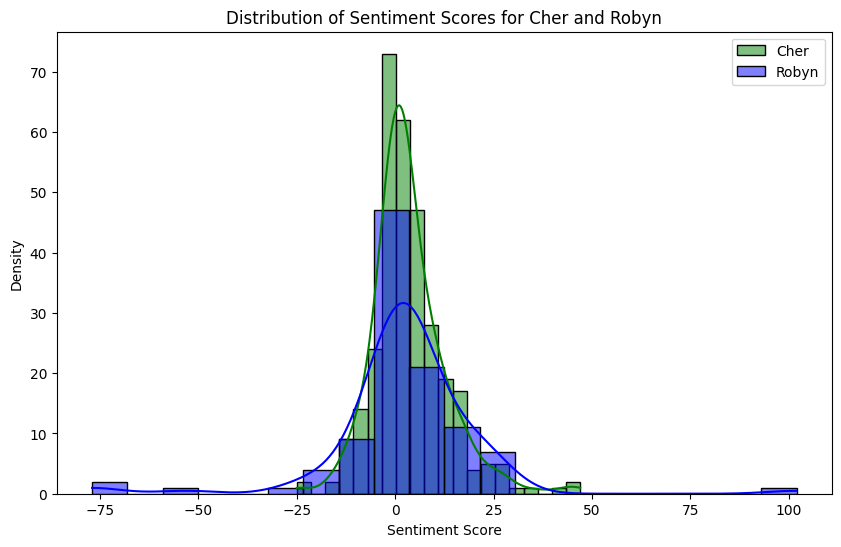

In [10]:

# Plot distribution of sentiment scores for Cher and Robyn
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_df['cher'].dropna(), kde=True, color='green', label='Cher', bins=20)
sns.histplot(sentiment_df['robyn'].dropna(), kde=True, color='blue', label='Robyn', bins=20)
plt.title('Distribution of Sentiment Scores for Cher and Robyn')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [31]:
# Inclusive Positive Emojis
positive_emojis = [ 
    "😀", "😃", "😄", "😁", "😆", "😅", "😂", "🤣", "😊", "😇",
    "🥰", "😍", "🤩", "😘", "😗", "😙", "😚", "🙌", "🎉", "🎊",
    "🎈", "🌈", "🌟", "🌻", "🌼", "🌺", "🍀", "🍎", "🍉", "🍒",
    "💖", "❤️", "💕", "💞", "💗", "💘", "💓", "💝", "💜", "💚",
    "💛", "🧡", "💙", "✨", "🥳", "🤗", "🥂", "🌅", "🌈", "💃",
    "🕺", "🎶", "🎵", "🌍", "🏆"
]

# Inclusive Negative Emojis
negative_emojis = [
    "😠", "😡", "🤬", "😔", "😟", "😢", "😭", "😱", "😨", "👎",
    "💔", "🖤", "☠️", "💩", "🪦", "⚰️", "🔥", "😩", "😤", "😒",
    "😣", "😖", "😓", "😕", "🤮", "😵", "💀", "😬", "😞", "😰",
    "🧨", "😩", "⚠️", "🕳️", "💔", "🔪", "😧", "👿"
]

from collections import Counter

# To calculate average sentiment and find most popular emojis
def calculate_average_sentiment(twitter_data):
    results = {}
    popular_positive = {}
    popular_negative = {}
    
    for artist, descriptions in twitter_data.items():
        # The artists for this analysis.
        if artist not in ['cher_followers', 'robynkonichiwa_followers']:
            total_score = 0
            emoji_count = 0
            positive_emoji_counter = Counter()
            negative_emoji_counter = Counter()
            
            for description in descriptions:
                for emoji in description:
                    if emoji in positive_emojis:
                        total_score += 1
                        emoji_count += 1
                        positive_emoji_counter[emoji] += 1
                    elif emoji in negative_emojis:
                        total_score -= 1
                        emoji_count += 1
                        negative_emoji_counter[emoji] += 1
            
            average_sentiment = total_score / emoji_count if emoji_count > 0 else 0
            results[artist] = {
                "average_sentiment": average_sentiment,
                "most_popular_positive": positive_emoji_counter.most_common(1)[0][0] if positive_emoji_counter else None,
                "most_popular_negative": negative_emoji_counter.most_common(1)[0][0] if negative_emoji_counter else None
            }
    
    return results

# To calculate average sentiment and most popular emojis for Twitter descriptions
average_sentiments = calculate_average_sentiment(twitter_data)

# Print of the results
for artist, data in average_sentiments.items():
    print(f"Artist: {artist}, Average Sentiment Score: {data['average_sentiment']:.5f}")
    print(f"Most popular positive emoji for {artist}: {data['most_popular_positive']}")
    print(f"Most popular negative emoji for {artist}: {data['most_popular_negative']}")
    


Artist: cher_followers_data, Average Sentiment Score: 0.79993
Most popular positive emoji for cher_followers_data: 🌈
Most popular negative emoji for cher_followers_data: 🖤
Artist: robynkonichiwa_followers_data, Average Sentiment Score: 0.81329
Most popular positive emoji for robynkonichiwa_followers_data: 🌈
Most popular negative emoji for robynkonichiwa_followers_data: 🖤


In [34]:
# Print.
print("\n The average sentiment of two artists are:")
print(f" Cher had an average sentiment of {average_sentiments['cher_followers_data']['average_sentiment']:.5f} and Robyn had an average sentiment of {average_sentiments['robynkonichiwa_followers_data']['average_sentiment']:.5f}.")



 The average sentiment of two artists are:
 Cher had an average sentiment of 0.79993 and Robyn had an average sentiment of 0.81329.


Q: What is the average sentiment of your two artists? 

A: The average sentiment of the Cher is 0.79 and the average sentiment of Robyn 0.81.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The positive emoji for Cher and Robyn is rainbow which is indication of hope, joy and diversity. And the negative emoji for Cher and Robyn is black heart which symbolises sadness, emotional pain and darkness.   



## References

OpenAI. (2024). ChatGPT (October 15 version) [Large language model]. https://chat.openai.com/